In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [188]:
encode_data = pd.read_csv('C:\\Users\\USER\\Desktop\\AMDARI\\CLASS\\PERISHABLEPRODUCT\\EDA\\encode.csv')
encode_data.head()

,Product_Name,Shelf_Life_Days,Units_Sold,Marketing_Spend,Discount_Percent,Wastage_Units,Price,Store_Size,Cold_Storage_Capacity,Supplier_Name,Lead_Time_Days,Supply_Capacity,Avg_Temperature,Rainfall,Holiday_Flag,Product_Category_Bakery,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Region_London,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Week_Number_Year,Week_Number_Month,Week_Number_Day,Month_Year,Month_Month,Month_Day
0,1870.339744,4,4853,670.37,0,718,2.46,12000,3788,1843.270513,3,48776,9.9,23.0,1,1,0,0,0,1,0,0,0,0,0,2024,1,1,2024,1,1
1,1870.339744,4,1911,1280.28,0,282,3.76,5000,1086,1843.270513,3,48776,7.4,32.1,0,1,0,0,0,0,1,0,0,0,0,2024,1,1,2024,1,1
2,1870.339744,4,3080,1509.55,0,455,3.81,4000,998,1843.270513,3,48776,6.4,32.4,0,1,0,0,0,0,0,1,0,0,0,2024,1,1,2024,1,1
3,1870.339744,4,2856,1101.11,0,422,1.09,5000,1243,1843.270513,3,48776,7.4,32.1,0,1,0,0,0,0,1,0,0,0,0,2024,1,1,2024,1,1
4,1870.339744,4,3211,1701.66,0,475,2.72,10000,3330,1843.270513,3,48776,9.9,23.0,1,1,0,0,0,1,0,0,0,0,0,2024,1,1,2024,1,1


Feature Selection with Mutual Info Regression

In [189]:
from sklearn.feature_selection import mutual_info_regression

# Define the feature and target matrix
X = encode_data.drop(columns=['Units_Sold'])
target = encode_data['Units_Sold']

# Compute mutual information scores
mi_scores = mutual_info_regression(X, target, random_state=42)

# Create DataFrame of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display the result
feature_importance


,Feature,MI_Score
4,Wastage_Units,3.513150
0,Product_Name,0.333857
1,Shelf_Life_Days,0.246444
17,Product_Category_Meat,0.208375
16,Product_Category_Dairy,0.165326
5,Price,0.159121
7,Cold_Storage_Capacity,0.139445
6,Store_Size,0.136043
18,Region_London,0.118336
12,Rainfall,0.080443


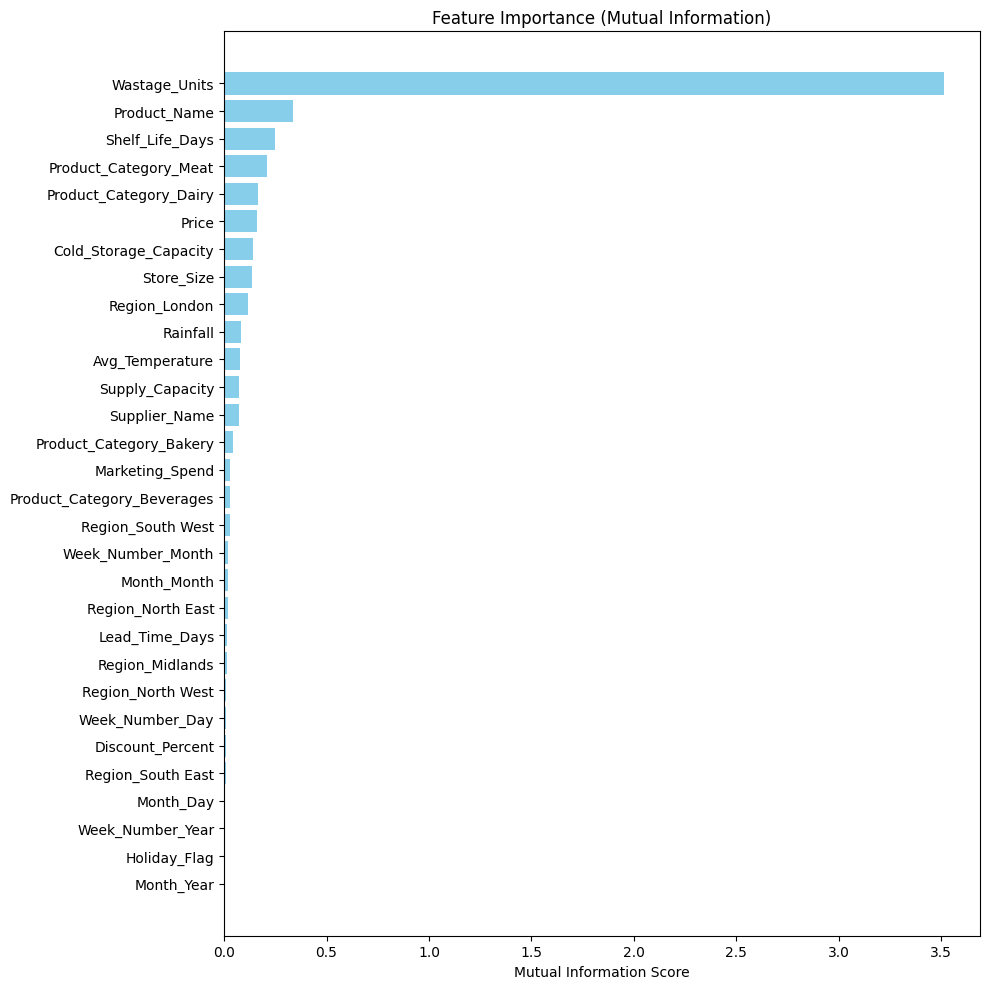

In [190]:
# Plotting
plt.figure(figsize=(10, 10))
plt.barh(feature_importance['Feature'], feature_importance['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


Analyses of features importance from Mutual Information: 

a) Top Predictors: Wastage_Units is by far the most informative feature that has strong influence on Units_Sold. Product_Name and Shelf_Life_Days also contribute but at much lower levels. Product categories like Meat and Dairy show moderate relevance.

b) Moderate Features: Price, Cold_Storage_Capacity, Store_Size, and some regions (like Region_London) provide minor information. Environmental variables such as Rainfall, Avg_Temperature, and Supply_Capacity show weak influence.

c) Low-to-Negligible Importance: Features like Marketing_Spend, Discount_Percent, Holiday_Flag, Time features (Month_Day, Week_Number_Year, etc.) show very low mutual information and may be uninformative or redundant.

Recommendations: Keep the first ten top predictors for training the model and drop very low score features that may add noise.

In [191]:
training_features = feature_importance['Feature'].head(10).tolist()
training_features

['Wastage_Units',
 'Product_Name',
 'Shelf_Life_Days',
 'Product_Category_Meat',
 'Product_Category_Dairy',
 'Price',
 'Cold_Storage_Capacity',
 'Store_Size',
 'Region_London',
 'Rainfall']

In [192]:
model_data = encode_data[training_features + ['Units_Sold']]
model_data.head()


,Wastage_Units,Product_Name,Shelf_Life_Days,Product_Category_Meat,Product_Category_Dairy,Price,Cold_Storage_Capacity,Store_Size,Region_London,Rainfall,Units_Sold
0,718,1870.339744,4,0,0,2.46,3788,12000,1,23.0,4853
1,282,1870.339744,4,0,0,3.76,1086,5000,0,32.1,1911
2,455,1870.339744,4,0,0,3.81,998,4000,0,32.4,3080
3,422,1870.339744,4,0,0,1.09,1243,5000,0,32.1,2856
4,475,1870.339744,4,0,0,2.72,3330,10000,1,23.0,3211


Training a Base Model

In [193]:
def train_linear_regression_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import (
        mean_squared_error,
        r2_score,
        mean_absolute_error,
        mean_absolute_percentage_error
    )
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)

    # Step 5: Predict on scaled test set
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 6: Inverse transform predictions and actual values
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 7: Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 8: Print evaluation metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [194]:
model_data = encode_data[training_features + ['Units_Sold']]
model = train_linear_regression_model(model_data)

MSE: 215878.7615
RMSE: 464.6276
R² Score: 0.8433
MAE: 316.4100
MAPE: 0.2287


Scaling: StandardScaler was applied to ensure that all features contribute equally to the model, preventing those with larger numerical ranges from dominating. It also helps optimization algorithms work more efficiently by improving the convergence of gradient-based models like Linear Regression.

In [195]:
def train_random_forest_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Convert to DataFrame/Series
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    y_scaled = pd.Series(y_scaled.flatten(), name=target_column)

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train Random Forest Regressor
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_scaled, y_train_scaled)
    
    # Step 5: Save the model
    import pickle 
    with open('rf_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    # Step 6: Predict (still in scaled units)
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 7: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # Step 8: Evaluate using real-world values
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 8: Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [196]:
model_data = encode_data[training_features + ['Units_Sold']]
model = train_random_forest_model(model_data)

MSE: 816.9775
RMSE: 28.5828
R² Score: 0.9994
MAE: 7.6153
MAPE: 0.0055


In [197]:
def train_svr_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVR
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train SVR
    model = SVR()
    model.fit(X_train_scaled, y_train_scaled.ravel())  # SVR expects 1D target

    # Step 5: Predict (still in scaled units)
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 6: Inverse transform predictions and actuals
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Step 7: Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 8: Print results
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [198]:
model_data = encode_data[training_features + ['Units_Sold']]
model = train_svr_model(model_data)

MSE: 28925.4420
RMSE: 170.0748
R² Score: 0.9790
MAE: 92.1891
MAPE: 0.0600


In [199]:
def train_xgboost_model(data, target_column='Units_Sold'):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    # Step 1: Split into features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Step 2: Scaling
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

    # Step 3: Train-test split
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.3, random_state=42
    )

    # Step 4: Train XGBoost Regressor
    model = XGBRegressor(random_state=42)
    model.fit(X_train_scaled, y_train_scaled.ravel())

    # Step 5: Predict
    y_pred_scaled = model.predict(X_test_scaled)

    # Step 6: Inverse transform
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Step 7: Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 8: Print results
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    return model


In [200]:
model_data = encode_data[training_features + ['Units_Sold']]
model = train_xgboost_model(model_data)

MSE: 7405.9167
RMSE: 86.0576
R² Score: 0.9946
MAE: 20.9910
MAPE: 0.0112


Metric Analyses:

R² Score (Goodness of Fit):
- Linear Regression: 0.8433 (Worst)
- Random Forest: 0.9994 (Best)
- SVR: 0.9790
- XGBoost: 0.9946
Analyses: Random Forest shows a significantly better fit, explaining 99.94% of the variance in the target variable and was followed closely XGBoost of 99.46%. 

RMSE (Root Mean Squared Error):
- Linear Regression: 464.6276  (Worst)
- Random Forest: 28.5828 (Best)
- SVR: 170.0748
- XGBoost: 86.0576
Analyses: Random Forest has the lowest RMSE at 28.5828, indicating its predictions are far closer to actual values while Linear Regression has the highest RMSE of 464.6276.

MAE (Mean Absolute Error):
- Linear Regression: 316.4100 (Worst)
- Random Forest: 7.6153 (Best)
- SVR: 92.1891
- XGBoost: 20.9910
Analyses: Again, Random Forest performs best with the lowest average prediction error, showing greater precision unlike linear regression with the lowest precision

MAPE (Mean Absolute Percentage Error):
- Linear Regression: 0.2287 (Worst)
- Random Forest: 0.0055 (Best)
- SVR: 0.0600
- XGBoost: 0.0112
Analyses: Random Forest achieves the most reliable and precise predictions with the lowest percentage error.

Result Interpretation:
Random Forest Regressor outperforms all the other models across all metrics. It delivers higher accuracy, lowest prediction error, captures non-linear patterns, and generalizes on unseen data better, making it the superior choice for production deployment in this case.
